# NEOAI-2025: The Hogspell Challenge

## Please Note:

The baseline **will not run on Kaggle** due to insufficient GPU memory (OOM error).

To run this notebook, you need **at least 20 GB of GPU memory.** You can use a free nvidia A10g (with 24gb vram) on lightning.ai

# Dataset creation

In [1]:
%pip install "torch<=2.7.0" "torchvision<=0.22.0" \
    -f https://download.pytorch.org/whl/torch_stable.html \
    diffusers==0.33.1 transformers==4.51.3 accelerate==1.6.0 hf-xet==1.1.0 \
    pillow==11.2.1 matplotlib==3.10.1 ipywidgets==8.1.7 \
    "scipy<2.0" "scikit-learn<2.0" \
    "networkx>=3.2.1" "sentencepiece>=0.1.99" \
    "pandas<3.0"

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.


In [2]:
import random
import numpy as np
import torch
import torch.nn as nn
import re
import os

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Seed {seed} has been set for random, NumPy, and PyTorch.")

set_seed(12782637)

Seed 12782637 has been set for random, NumPy, and PyTorch.


In [3]:
import os
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image
from torchvision import transforms

OUTPUT_DIR = "./dataset"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on device: {DEVICE}")

# Create folder
os.makedirs(OUTPUT_DIR, exist_ok=True)

Running on device: cuda


# Model preparation

In [4]:
# Load SD 1.5
print("Loading SD 1.5 model...")

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", 
    torch_dtype=torch.float32,
)\
.to(DEVICE)

pipe.safety_checker = None

Loading SD 1.5 model...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
def generate_instance_dataset(
    pipe,
    NUM_STEPS=50,
    seed=12782637
):
    # Different styles for diversity
    styles=[
        "realistic photo", "watercolor", "oil painting", "3D render", "cartoon", "impressionist's art", 
        "head", "photo", "shot", "drawing", "painting"
    ]
    prompts_1 = [f"{style} of a pig" for style in styles]

    styles = ["landscape",
              "countryside picture",
              "backyard",
              "farm",
              "background"]
    prompts_2 = [f"{style} with a pig" for style in styles]

    prompts_3 = ["one pig or many in nature",
                 "one pig or many at a farm",
                 "drawing of a pig or many"]

    prompts_4 = ["one pig and many more with other animals"]

    prompts_5 = ["image without any pig"]

    prompts_6 = ["image without any pig or other animal"]

    repetitions = 10
    prompts = prompts_1 + prompts_2 + prompts_3 + prompts_4 + prompts_5 + prompts_6

    # Save prompts for training
    with open(os.path.join(OUTPUT_DIR, "instance_prompts.txt"), "w") as f:
        for prompt in prompts:
            for ix in range(repetitions):
                f.write(prompt + "\n")

    # Generate images
    for i, prompt in enumerate(prompts):
       print(f"Generating {i+1}/{len(prompts)}: '{prompt}'")
       image = pipe(prompt=prompt, num_inference_steps=NUM_STEPS, seed=seed).images[0]
       for ix in range(repetitions):
           counter = repetitions * i + ix
           image_path = os.path.join(OUTPUT_DIR, f"instance_{counter:03d}.png")
           image.save(image_path)

    print(f"Dataset created: {len(prompts) * repetitions} images") # 220

In [6]:
gen_dataset = False
if gen_dataset:
    generate_instance_dataset(pipe=pipe)

# Fine-tune

In [7]:
FINETUNE_DIR = "./model"
os.makedirs(FINETUNE_DIR, exist_ok=True)

In [8]:
def finetune_model(
    pipe,
    OUTPUT_DIR=OUTPUT_DIR,
    FINETUNE_DIR=FINETUNE_DIR,
    LR=1e-5,
    NUM_EPOCHS=3
):
    print("Preparing for fine-tuning...")

    # Image transformer
    image_transforms = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ])

    # load instance prompts (photos of pigs)
    with open(os.path.join(OUTPUT_DIR, "instance_prompts.txt"), "r") as f:
        instance_prompts = [line.strip() for line in f.readlines()]
  
    # Freeze everything except UNet
    pipe.vae.requires_grad_(False)
    pipe.text_encoder.requires_grad_(False)
    pipe.unet.requires_grad_(True)

    # Optimizer
    optimizer = torch.optim.AdamW(pipe.unet.parameters(), lr=LR)

     # Gather instance and class image paths
    all_files = os.listdir(OUTPUT_DIR)
    instance_images = sorted(
        [os.path.join(OUTPUT_DIR, f) for f in all_files
         if re.match(r"instance_\d{3}\.png$", f)]
    )

    mse = nn.MSELoss()
    scheduler = pipe.scheduler

    # Replace "pig" with "horse" in prompts
    # instance_prompts = [prompt.replace("pig", "horse") for prompt in instance_prompts]

    # Fine-tuning
    print("Starting fine-tuning...")
    for epoch in range(1, NUM_EPOCHS + 1):
        for i, (inst_path, inst_prompt) in enumerate(zip(instance_images, instance_prompts)):
            # Load and encode instance image
            inst_img = Image.open(inst_path).convert("RGB")
            inst_tensor = image_transforms(inst_img).unsqueeze(0).to(DEVICE)
            with torch.no_grad():
                inst_latent = pipe.vae.encode(inst_tensor).latent_dist.sample() * 0.18215

            # Prepare text embeddings
            with torch.no_grad():
                if random.random() <= 0.5:
                    _inst_prompt = inst_prompt.replace("pig", "horse")
                else:
                    _inst_prompt = inst_prompt

                inst_ids = pipe.tokenizer(_inst_prompt,
                                          padding="max_length",
                                          truncation=True,
                                          max_length=pipe.tokenizer.model_max_length,
                                          return_tensors="pt").input_ids.to(DEVICE)

                inst_emb = pipe.text_encoder(inst_ids)[0]

            # Sample noise and timestep
            noise_inst = torch.randn_like(inst_latent)
            timesteps = torch.randint(
                0, scheduler.config.num_train_timesteps,
                (1,), device=DEVICE
            )

            # Add noise
            noisy_inst = scheduler.add_noise(inst_latent, noise_inst, timesteps)

            # Predict noise with UNet
            pipe.unet.train()
            pred_inst = pipe.unet(noisy_inst, timesteps, inst_emb).sample

            # Compute losses
            loss_inst = mse(pred_inst, noise_inst)
            loss = loss_inst

            # Backprop and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 10 == 0 or i == 0:
                print(f"Epoch {epoch} | Step {i+1}/{len(instance_images)} "
                    f"| Total Loss: {loss.item():.4f}")

    # Save the fine-tuned model
    print("Saving fine-tuned model...")
    pipe.unet.save_pretrained(os.path.join(FINETUNE_DIR, "unet"))
    pipe.save_pretrained(FINETUNE_DIR)

    return pipe

In [9]:
finetune_model(pipe)
print("Done! Model fine-tuned and saved.")

Preparing for fine-tuning...
Starting fine-tuning...


Epoch 1 | Step 1/220 | Total Loss: 0.0430
Epoch 1 | Step 10/220 | Total Loss: 0.0054
Epoch 1 | Step 20/220 | Total Loss: 0.1839
Epoch 1 | Step 30/220 | Total Loss: 0.0843
Epoch 1 | Step 40/220 | Total Loss: 0.0740
Epoch 1 | Step 50/220 | Total Loss: 0.0039
Epoch 1 | Step 60/220 | Total Loss: 0.0983
Epoch 1 | Step 70/220 | Total Loss: 0.0647
Epoch 1 | Step 80/220 | Total Loss: 0.0116
Epoch 1 | Step 90/220 | Total Loss: 0.0424
Epoch 1 | Step 100/220 | Total Loss: 0.0026
Epoch 1 | Step 110/220 | Total Loss: 0.3554
Epoch 1 | Step 120/220 | Total Loss: 0.0557
Epoch 1 | Step 130/220 | Total Loss: 0.4579
Epoch 1 | Step 140/220 | Total Loss: 0.0107
Epoch 1 | Step 150/220 | Total Loss: 0.0200
Epoch 1 | Step 160/220 | Total Loss: 0.0762
Epoch 1 | Step 170/220 | Total Loss: 0.1028
Epoch 1 | Step 180/220 | Total Loss: 0.3755
Epoch 1 | Step 190/220 | Total Loss: 0.0561
Epoch 1 | Step 200/220 | Total Loss: 0.0844
Epoch 1 | Step 210/220 | Total Loss: 0.0717
Epoch 1 | Step 220/220 | Total Loss: 0.0223

# Submission

In [10]:
pipe = StableDiffusionPipeline.from_pretrained(
    FINETUNE_DIR, 
    torch_dtype=torch.float32,
)\
.to(DEVICE)

pipe.safety_checker = None

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [11]:
import os
import torch
from PIL import Image
from io import BytesIO
import base64
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

def image_to_base64(image: Image.Image, fmt: str = "PNG") -> str:
    """ Converts PIL.Image to base64 (text format). """
    buf = BytesIO()
    image.save(buf, format=fmt)
    return base64.b64encode(buf.getvalue()).decode("utf-8")

def base64_to_image(base64_str: str) -> Image.Image:
    """ Loads image back from base64 to PIL.Image. """
    img_data = base64.b64decode(base64_str)
    img = Image.open(BytesIO(img_data))
    return img

In [12]:
def prompts_to_dataframe(
    pipe: StableDiffusionPipeline,
    prompts: dict,
    batch_size: int = 10,
    num_steps: int = 30,
    guidance: float = 7.5,
    device: str = "cuda",
    seed: int = 12782637,
) -> pd.DataFrame:
    """
    Generates images for prompts using the given pipeline.
    Runs in batches (which significantly speeds up the process).
    """
    pipe.to(device)

    if pipe.safety_checker is not None:
        pipe.safety_checker = lambda imgs, **kw: (imgs, False)

    ids, b64 = [], []
    keys, texts = list(prompts.keys()), list(prompts.values())

    # Run prompts in batches
    for i in range(0, len(texts), batch_size):
        batch_prompts = texts[i:i+batch_size]

        with torch.autocast(device_type=str(device)):
            out = pipe(
                batch_prompts,
                num_inference_steps=num_steps,
                guidance_scale=guidance,
                seed=seed
            ).images

        # Immediately convert to base64
        for k, img in zip(keys[i : i + batch_size], out):
            ids.append(k)
            b64.append(image_to_base64(img))

        print(f"Generated {i + len(batch_prompts)} / {len(texts)}")
        # if i + len(batch_prompts) >= 20:
        #     break

    return pd.DataFrame({"id": ids, "0": b64})


def save_dataframe(df: pd.DataFrame, path: str) -> None:
    df.to_csv(path, index=False)
    print(f"CSV saved: {os.path.abspath(path)}")

In [13]:
import json

with open("./prompts.json", "r") as file:
    prompts = json.load(file)

df = prompts_to_dataframe(pipe, prompts, device=DEVICE)

  0%|          | 0/30 [00:00<?, ?it/s]

Generated 10 / 182


  0%|          | 0/30 [00:00<?, ?it/s]

Generated 20 / 182


  0%|          | 0/30 [00:00<?, ?it/s]

Generated 30 / 182


  0%|          | 0/30 [00:00<?, ?it/s]

Generated 40 / 182


  0%|          | 0/30 [00:00<?, ?it/s]

Generated 50 / 182


  0%|          | 0/30 [00:00<?, ?it/s]

Generated 60 / 182


  0%|          | 0/30 [00:00<?, ?it/s]

Generated 70 / 182


  0%|          | 0/30 [00:00<?, ?it/s]

Generated 80 / 182


  0%|          | 0/30 [00:00<?, ?it/s]

Generated 90 / 182


  0%|          | 0/30 [00:00<?, ?it/s]

Generated 100 / 182


  0%|          | 0/30 [00:00<?, ?it/s]

Generated 110 / 182


  0%|          | 0/30 [00:00<?, ?it/s]

Generated 120 / 182


  0%|          | 0/30 [00:00<?, ?it/s]

Generated 130 / 182


  0%|          | 0/30 [00:00<?, ?it/s]

Generated 140 / 182


  0%|          | 0/30 [00:00<?, ?it/s]

Generated 150 / 182


  0%|          | 0/30 [00:00<?, ?it/s]

Generated 160 / 182


  0%|          | 0/30 [00:00<?, ?it/s]

Generated 170 / 182


  0%|          | 0/30 [00:00<?, ?it/s]

Generated 180 / 182


  0%|          | 0/30 [00:00<?, ?it/s]

Generated 182 / 182


In [14]:
def save_submission(df, nb_path: str = None):
    """
    You don't necessarily need to understand what's going on here.

    This is a function for saving your submission with a hash and the code of the current notebook (makes it easier to find and compare them later).
    The main thing is to pass your submission DataFrame into it — it will take care of the rest.
    """
    import json, shutil, hashlib, pathlib, urllib.request
    from datetime import datetime
    from IPython import get_ipython

    if nb_path is None:
        try:
            from notebook import notebookapp
            connection_file = get_ipython().kernel.get_connection_file()
            kernel_id = pathlib.Path(connection_file).stem.split('-', 1)[1]
            nb_path = None
            for srv in notebookapp.list_running_servers():
                try:
                    token = f"?token={srv.get('token', '')}" if srv.get('token') else ""
                    with urllib.request.urlopen(srv["url"] + "api/sessions" + token) as resp:
                        sessions = json.load(resp)
                    for s in sessions:
                        if s["kernel"]["id"] == kernel_id:
                            nb_path = pathlib.Path(srv["notebook_dir"]) / s["notebook"]["path"]
                            break
                except: continue
                if nb_path: break
        except: nb_path = None

    if nb_path is None:
        candidates = sorted(pathlib.Path(".").glob("*.ipynb"), key=lambda p: p.stat().st_mtime, reverse=True)
        if not candidates:
            raise RuntimeError("Failed to determine the path to the notebook. Please specify it explicitly via nb_path.")
        nb_path = candidates[0]

    nb_path = pathlib.Path(nb_path)

    csv_bytes = df.to_csv(index=False).encode("utf-8")
    df_sha = hashlib.sha256(csv_bytes).hexdigest()
    csv_name = f"submit_{df_sha[:8]}.csv"

    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    folder_name = f"({df_sha[:8]}) {timestamp}"
    submit_dir = pathlib.Path("@submits") / folder_name
    submit_dir.mkdir(parents=True, exist_ok=True)

    copied_nb_path = submit_dir / nb_path.name
    shutil.copy2(nb_path, copied_nb_path)
    notebook_sha = hashlib.sha256(copied_nb_path.read_bytes()).hexdigest()

    csv_path = submit_dir / csv_name
    csv_path.write_bytes(csv_bytes)

    meta = {
        "notebook_file": copied_nb_path.name,
        "notebook_sha256": notebook_sha,
        "dataframe_file": csv_name,
        "dataframe_sha256": df_sha,
        "generated_at": timestamp,
    }
    (submit_dir / "hashes.json").write_text(json.dumps(meta, indent=2, ensure_ascii=False), encoding="utf-8")

    print("Notebook:", copied_nb_path)
    print("CSV:", csv_path)
    print("Meta:", submit_dir / "hashes.json")


save_submission(df)

Notebook: @submits/(9f509fde) 2025-06-11 13:25:28/6-no-db.ipynb
CSV: @submits/(9f509fde) 2025-06-11 13:25:28/submit_9f509fde.csv
Meta: @submits/(9f509fde) 2025-06-11 13:25:28/hashes.json


## Evaluation (validation)

Let's look at the prompts manually, map some of them by hand, and validate on that.

In [15]:
import torch
from transformers import CLIPProcessor, CLIPModel

clip_model = CLIPModel.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K")\
    .eval()\
    .to(DEVICE)

clip_processor = CLIPProcessor.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [16]:
val_prompts = [(key, value) for key, value in prompts.items()][:20]
val_prompts

[('0', 'Fantasy Boar Art'),
 ('1', 'Photoreal CGI Thoroughbred'),
 ('2', 'A creature that unicorn is based on'),
 ('3', 'Symbolist Mare Imagery'),
 ('4', 'Holographic Style depicting an Equine'),
 ('5', 'Gentle giant grazing on dew-kissed pasture'),
 ('6', 'Creature known for digging, oinking, and endless appetite.'),
 ('7', 'Baroque Stallion Painting'),
 ('8', 'Wild boars roaming through misty autumn forest, golden leaves'),
 ('9', 'Mangalitsa'),
 ('10', 'Barn swallows nesting in rafters, mud nests, flying insects'),
 ('11', 'Claymation/Stop Motion Horse'),
 ('12', 'Cattle dogs herding sheep, skilled working animals, green pastures'),
 ('13', 'Minimalist Stallion Design'),
 ('14', "Farmer's market with fresh produce, handmade goods, rural charm"),
 ('15', 'A knight riding through the field'),
 ('16',
  "Silent listener twitching ears toward distant hoofbeats at the meadow's edge"),
 ('17', 'Quiet creature nuzzling fresh hay'),
 ('18', 'Buffalo herd crossing prairie landscape, tall gra

In [17]:
# 🤔
# 0 – horse
# 1 – pig
# 2 – neutral
labels = {
     0: 1,
     1: 0,
     2: 0,
     3: 0,
     4: 0,
     5: 0,
     6: 1,
     7: 0,
     8: 1,
     9: 1,
    10: 2,
    11: 0,
    12: 2,
    13: 0,
    14: 2,
    15: 0,
    16: 0,
    17: 0,
    18: 2,
    19: 0,
}

mapping = pd.DataFrame({
    'id': list(labels.keys()),
    '0':  list(labels.values())
})

In [18]:
def load_images(submission):
    return submission['0'].apply(base64_to_image)

submission = df.iloc[:20]
images = load_images(submission)

In [19]:
def get_clip_classes(row):
    """ Target is always the zero class. For convenience. """
    if str(row['0']) == "2":
        # Validation prompt case
        classes = [prompts.get(str(row['id'])), "pig", "horse", ""]
    else:
        # Horse prompt and Pig prompt cases
        classes = ["pig", "horse", "noise", ""]
    return classes

classes_to_clip = mapping.apply(get_clip_classes, axis=1)

In [20]:
from tqdm.auto import tqdm

@torch.inference_mode()
def score_samples(images: pd.Series, classes: pd.Series) -> float:
    predicted_classes = []
    total = {}

    for img, prompts in zip(images, classes):
        inp = clip_processor(
            text=prompts, 
            images=[img], 
            return_tensors="pt", 
            padding=True
        )\
        .to(DEVICE)

        logits = clip_model(**inp).logits_per_image.squeeze(0)  # (N,)
        pred_idx = int(logits.argmax())
        predicted_classes.append(pred_idx)

    return pd.Series(predicted_classes, index=classes.index)


def mean_harmonic(values: list) -> float:
    """ Harmonic mean for list of values."""
    positives = [v for v in values if v > 0]
    if not positives:
        return 0.0
    return len(positives) / sum(1 / v for v in positives)


def compute_score(predicted_classes, ground_truth):
    is_right = (predicted_classes == 0)
    average_by_classes = is_right.groupby(ground_truth['0']).mean()
    score = (mean_harmonic(average_by_classes))
    return score

In [21]:
predicted_classes = score_samples(images, classes_to_clip)
computed_score = compute_score(predicted_classes, mapping)

computed_score

0.8761061946902656

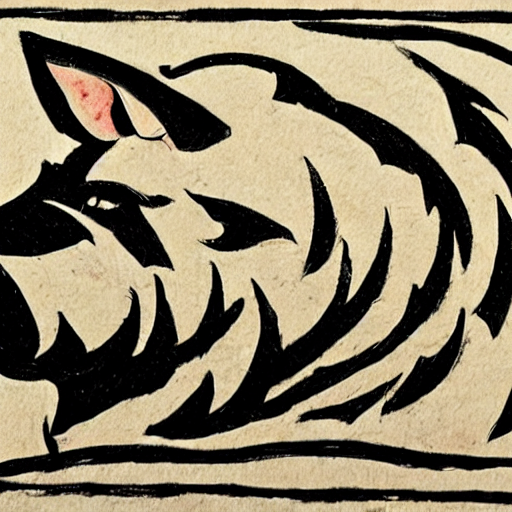

In [22]:
# Let's at least take a look at the image
images[0]

🙂